In [1]:
import numpy as np
import cov_script as cs
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=240)

Get the correlation matrix of Ups_gm, Ups_gg and beta, using Shadab's Cov(Ups_gx, beta) elements estimated from simulations.

First compute and load the covariance matrix from the JN simulations + HOD samples computed by Shadab.

In [4]:
cov_corr_dict = cs.evaluate_correlation_matrix(stat_list=['gm','gg', 'beta'],rmin=1.6,plots=0,data_dir='')

In [5]:
print(cov_corr_dict['cov'].shape)
# Okay, so we know there are 15 rp bins for Upgg and Upgm, and one value of beta. Beta is at the end (checked)

(31, 31)


In [6]:
print(cov_corr_dict['cov'])

[[ 3.17456504e-02  6.04500329e-03  2.71994656e-03  1.09530226e-03  1.85728204e-03  1.29848029e-03  2.05057048e-03  2.16401717e-03  2.53128604e-03  3.02897938e-03  2.80986180e-03  1.94093334e-03  1.27834294e-03 -4.30314215e-06
  -6.84845567e-04  2.09092444e-02  1.06029418e-02 -7.68988595e-03 -8.10339725e-04  2.77533477e-04  1.57992568e-03  8.36804646e-04  3.98382499e-03  5.68255988e-03  3.65873412e-03  3.85048863e-03  1.40369600e-03  1.15102563e-03
   2.13721453e-04 -2.13536046e-04  1.72696656e-04]
 [ 6.04500329e-03  2.60295515e-02  1.05842853e-02  6.34713953e-03  4.41653982e-03  4.23186690e-03  1.81377740e-03  1.79203944e-03  1.78138880e-03  1.58741978e-03  1.87573816e-03  1.92694732e-03  1.81484031e-03  1.28404829e-03
   2.00178105e-03  2.19161194e-02  2.98302800e-02  1.07580701e-02  7.55516369e-03  6.55270900e-03  6.27212309e-03  4.04874500e-03  3.86705508e-03  3.74280153e-03  2.21701303e-03  1.19584661e-03  8.52484366e-04  2.22465501e-03
   1.62086159e-03  4.02099138e-03 -2.95907675

We need to make sure everything is in the same units. I believe that Shadab's Upsilons are in units Mpc/h, whereas mine are in units Msol * h / pc^2. The factor to get them in the same units is rho_crit in particular units.

In [7]:
mperMpc = 3.0856776*10**22
Msun = 1.989*10**30 # in kg
Gnewt = 6.67408*10**(-11)
c=2.99792458*10**(8)
rho_crit = 3. * 10**10 * mperMpc / (8. * np.pi * Gnewt * Msun) / 10**12  
OmegaM = 0.3
# Msol h^2 / Mpc / pc^2, to yield Upsilon_gg in Msol h / pc^2

For Upsilon x beta, we should multiple by a single factor of rho_crit. For Upsilon x Upsilon, two factors.
In the case of Upsilon_gm, the sims stuff also has a missing factor of Omega_M whic we need to add.

Now load my analytical calculation of the covariance matrix (using in part Sukdheep's old Hankel transform code).

In [8]:
# This is linear only? I should deal with this. 
# The covariance to compare with sims should include nonlinear elements.
cov_Danielle = np.loadtxt('./Danielle_cov_JP.dat')

In [9]:
print(cov_Danielle.shape)
# Good, it's the same shape.

(31, 31)


Now let's make the combined covariance matrix. Remember to multiply the elements from Shadab by rho_crit to get the right units. We also rescale to account for the difference between the volume that goes into our analytic covariance and the volume of Shadab's sim (even though they are very close).

In [10]:
volume_factor = 2.5*10**9 / (2.6 * 10**9)
print(volume_factor)

0.961538461538


In [11]:
combined_cov = np.zeros_like(cov_Danielle)

In [12]:
combined_cov[0:15,0:15] = cov_Danielle[0:15,0:15] # gm x gm
combined_cov[0:15,15:30] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][0:15, 15:30] #gm x gg
combined_cov[15:30,0:15] = rho_crit**2*volume_factor*OmegaM*cov_corr_dict['cov'][15:30, 0:15] #gm x gg
combined_cov[15:30, 15:30] = rho_crit**2*volume_factor*cov_corr_dict['cov'][15:30, 15:30] #gg x gg
combined_cov[30,0:15] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][30, 0:15] # gm x beta
combined_cov[30,15:30] = rho_crit*volume_factor*cov_corr_dict['cov'][30, 15:30] # gg * beta
combined_cov[0:15,30] = rho_crit*OmegaM*volume_factor*cov_corr_dict['cov'][0:15,30] # gm x beta
combined_cov[15:30,30] = rho_crit*volume_factor*cov_corr_dict['cov'][15:30, 30] # gg x beta
combined_cov[30,30] = volume_factor*cov_corr_dict['cov'][30, 30] # beta x beta

In [13]:
# Just checking no elements are left as zero
print(np.amin(np.abs(combined_cov)))

4.633359637454901e-08


Now from this covariance matrix get the correlations matrix.

In [14]:
combined_corr = np.zeros_like(combined_cov)
for i in range(0,len(combined_corr[0,:])):
    for j in range(0,len(combined_corr[:,0])):
        combined_corr[i,j] = combined_cov[i,j] / np.sqrt(combined_cov[i,i] * combined_cov[j,j])       

Let's look numerically at the correlation values for Ups_gm / beta and Ups_gg beta

In [15]:
# Corr(Ups_gm, beta)
print("Corr(Ups_gm, beta)=", combined_corr[30,0:15])
# Corr(Ups_gg, beta)
print( "Corr(Ups_gg, beta)=", combined_corr[30,15:30])

('Corr(Ups_gm, beta)=', array([ 0.10472538, -0.05137952, -0.01941074, -0.06506051, -0.08194492, -0.2130356 , -0.19096668, -0.16768294, -0.15891102, -0.27547211, -0.27108225, -0.27137245, -0.13602905, -0.0122696 ,  0.05679069]))
('Corr(Ups_gg, beta)=', array([-0.08393546,  0.0508295 ,  0.0339485 , -0.05847249, -0.07322581, -0.33188989, -0.30100203, -0.05535315, -0.14034052, -0.25030735, -0.38986924, -0.43637315, -0.33089297, -0.28649783, -0.19134477]))


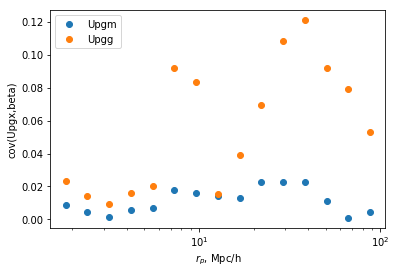

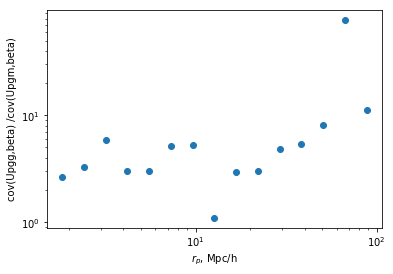

In [16]:
rp = np.loadtxt(
    './test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon')[:,0]
rp_cut = rp[10:]
plt.figure()
plt.semilogx(rp_cut, np.abs(rho_crit * OmegaM *combined_corr[30, 0:15]), 'o', label="Upgm")
plt.semilogx(rp_cut, np.abs(rho_crit * combined_corr[30, 15:30]), 'o', label="Upgg")
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("cov(Upgx,beta)")
plt.legend()
plt.show()

plt.figure()
plt.loglog(rp_cut,np.abs(combined_corr[30, 15:30]) / np.abs(OmegaM*combined_corr[30, 0:15]), 'o')
plt.xlabel("$r_p$, Mpc/h")
plt.ylabel("cov(Upgg,beta) /cov(Upgm,beta)")
plt.show()

Okay so, good news, cov(Upsilon_gm, beta) seems to be considerably smaller than cov(Upsilon_gg, beta). That's what we would expect, and it also justifies not caring about the cov(cosmic shear, beta) terms.

Let's look at Shadab's Cov(Ups_gm, Ups_gm) vs mine. Mine should in principle be larger on the diagonal because it includes shape noise.

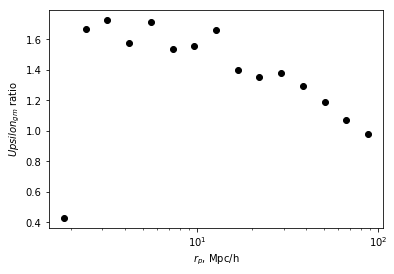

In [17]:
# Shadab diagonal Ups_gm, Ups_gm
#print np.diag(cov_corr_dict_gm['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[0:15,0:15])

plt.figure()
plt.semilogx(rp_cut, 
         np.sqrt(np.diag(combined_cov[0:15,0:15])) / np.sqrt(np.diag(rho_crit**2*volume_factor* OmegaM**2*
                                                                     cov_corr_dict['cov'][0:15,0:15])), 
         'ko')
plt.ylabel("$Upsilon_{gm}$ ratio")
plt.xlabel("$r_p$, Mpc/h")
plt.show()

In principle, my cov(Upsilon_gg, Upsilon_gg) and Shadab's cov(Upsilon_gg, Upsilon_gg) should agree.

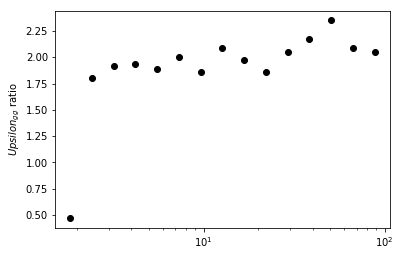

In [18]:
# Shadab diagonal Ups_gg, Ups_gg
#print np.diag(cov_corr_dict_gg['cov'][0:15,0:15])
# Mine diagonal Ups_gm, Ups_gm
#print np.diag(combined_cov[15:30,15:30])

plt.figure()
plt.semilogx(rp_cut, 
         np.sqrt(np.diag(cov_Danielle[15:30,15:30])) / np.sqrt(np.diag(rho_crit**2*volume_factor*
                                                                       cov_corr_dict['cov'][15:30,15:30])), 
         'ko')
plt.ylabel("$Upsilon_{gg}$ ratio")
plt.show()

In [19]:
# My cov(beta, beta) is only shot noise whereas Shadab's should be shot noise and cosmic variance
print("Shadab, sigma(beta)=", np.sqrt(volume_factor* cov_corr_dict['cov'][30,30]))
print("My sigma(beta)=", np.sqrt(cov_Danielle[30,30]))

('Shadab, sigma(beta)=', 0.021056576920207824)
('My sigma(beta)=', 0.00605611675362)


Right so my cov(Upsilon_gg, Upsilon_gg) should agree with Shadab's but the error on the diagonal is larger by about 2 (meaning the covariance is off by about 4). What's wrong?